In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from matplotlib import pyplot as plt
from IPython.display import clear_output
import numpy as np
import pandas as pd
import seaborn as sns
import simdna
from simdna import synthetic
import statsmodels.api as sm
import torch
from tqdm.auto import tqdm

from utils import one_hot_decode
from in_silico_mutagenesis import compute_summary_statistics, generate_wt_mut_batches, write_results
from pyx.one_hot import one_hot
from tf_coop_model import CountsRegressor, IterablePandasDataset
from tf_coop_model import anscombe_transform, run_one_epoch, spearman_rho, pearson_r
from tf_coop_simulation import background_frequency
from tf_coop_simulation import simulate_counts, simulate_oracle_predictions

/home/stephen/anaconda3/envs/deepmr/lib/python3.6/site-packages/dask/dataframe/utils.py:13: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
np.random.seed(42)

In [22]:
sequence_length = 100
includes_confounder = True

data_dir = '../dat/sim_e2e_conf'
test_data_fpath = os.path.join(data_dir, 'test_labels.csv')
raw_simulation_data_fpath = os.path.join(data_dir, 'test_sequences.simdata')

sequences_col = "sequences"
label_cols = ["labels_exp", "labels_out"]
batch_size = 1000
n_samples = 10

exposure_col = 1
outcome_col = 0
exposure_name = "GATA"
outcome_name = "TAL1"
exposure_motif = "GATA_disc1"
outcome_motif = "TAL1_known1"
confounder_motif = "SOX2_1" if includes_confounder else None

In [23]:
torch.set_grad_enabled(False)

# Load Test Data & Generate Predictions
Now we're going to load test data to get some basic metrics about how well our model performs.

In [24]:
test_df = pd.read_csv(test_data_fpath)
test_dataset = IterablePandasDataset(
    test_df, x_cols=sequences_col, y_cols=label_cols, x_transform=one_hot,
)
test_data_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, num_workers=0
)

test_df.head()

,sequences,labels_exp,labels_out,has_exposure,has_outcome,has_both,has_confounder
0,GAAAGGGATCAAGCTCCAGATAAGGGGTTAGAGGGTAGCCTGACGG...,113,111,1,1,1,0
1,TAATCCCATCGGTGAGCCTTCGTGGGTGCTCAGTCCTAAACAGTAT...,18,39,0,1,0,1
2,GATCTCTTCATGTCGAGCCGGTCCGTATGCGATAAGAACCATTTAG...,123,27,1,0,0,1
3,TGTAACTGTCAATATGATTTGTCACTCTAATCCTGAAAAATCCCAT...,103,37,1,0,0,0
4,CAGGTATTTGATACTAGAACGAGAGCATGCAGTCCCTTATACCATT...,17,32,0,0,0,1


In [25]:
simdata = synthetic.read_simdata_file(raw_simulation_data_fpath)


In [26]:
simdata.embeddings[0][0].what.string, simdata.embeddings[0][0].what.getDescription()

('CCAGATAAGG', 'GATA_disc1')

In [35]:
ex_embeds = None
for embeds in simdata.embeddings:
    if len(embeds) == 5:
        ex_embeds = embeds
        break

In [53]:
for embed in ex_embeds:
        print(type(embed.what))
        print(embed.what.stringDescription)
        print(embed.startPos)

<class 'simdna.synthetic.embeddables.StringEmbeddable'>
GATA_disc1
2
<class 'simdna.synthetic.embeddables.StringEmbeddable'>
TAL1_known1
47
<class 'simdna.synthetic.embeddables.StringEmbeddable'>
GATA_disc1
2
<class 'simdna.synthetic.embeddables.StringEmbeddable'>
TAL1_known1
47
<class 'simdna.synthetic.embeddables.StringEmbeddable'>
SOX2_1
14


In [43]:
type()

AttributeError: 'StringEmbeddable' object has no attribute 'startPos'

In [57]:

def simdata_to_start_pos_df(simdata, exposure_motif, outcome_motif, confounder_motif=None):
    sequences = simdata.sequences
    embeddings = simdata.embeddings
    name_to_type = {
        exposure_motif: ('exposure_start_pos', 'exposure_end_pos'),
        outcome_motif: ('outcome_start_pos', 'outcome_end_pos'),
    }
    if confounder_motif is not None:
        name_to_type[confounder_motif] = ('confounder_start_pos', 'confounder_end_pos')
    motif_range_by_type = {
        'sequences': simdata.sequences,
        'exposure_start_pos': -1 * np.ones(len(embeddings), dtype=np.int),
        'outcome_start_pos': -1 * np.ones(len(embeddings), dtype=np.int),
        'confounder_start_pos': -1 * np.ones(len(embeddings), dtype=np.int),
        'exposure_end_pos': -1 * np.ones(len(embeddings), dtype=np.int),
        'outcome_end_pos': -1 * np.ones(len(embeddings), dtype=np.int),
        'confounder_end_pos': -1 * np.ones(len(embeddings), dtype=np.int)
    }
    for i, seq_embeds in enumerate(embeddings):
        for seq_embed in seq_embeds:
            keys = name_to_type[seq_embed.what.getDescription()]
            motif_len = len(seq_embed.what.string)
            motif_range_by_type[keys[0]][i] = int(seq_embed.startPos)
            motif_range_by_type[keys[1]][i] = int(seq_embed.startPos) + motif_len
    return pd.DataFrame(motif_range_by_type)

start_pos_df = simdata_to_start_pos_df(simdata, exposure_motif, outcome_motif, confounder_motif=confounder_motif)
start_pos_df.head()

,sequences,exposure_start_pos,outcome_start_pos,confounder_start_pos,exposure_end_pos,outcome_end_pos,confounder_end_pos
0,GAAAGGGATCAAGCTCCAGATAAGGGGTTAGAGGGTAGCCTGACGG...,15,78,-1,25,94,-1
1,TAATCCCATCGGTGAGCCTTCGTGGGTGCTCAGTCCTAAACAGTAT...,-1,73,49,-1,89,64
2,GATCTCTTCATGTCGAGCCGGTCCGTATGCGATAAGAACCATTTAG...,27,-1,75,37,-1,90
3,TGTAACTGTCAATATGATTTGTCACTCTAATCCTGAAAAATCCCAT...,54,-1,-1,64,-1,-1
4,CAGGTATTTGATACTAGAACGAGAGCATGCAGTCCCTTATACCATT...,-1,-1,41,-1,-1,56


In [215]:
test_df = pd.merge(test_df, start_pos_df, on="sequences")
test_df.head()

,sequences,labels_exp,labels_out,has_exposure,has_outcome,has_both,has_confounder,exposure_start_pos,outcome_start_pos,exposure_end_pos,outcome_end_pos
0,ATCCTGTATACCGTGTCTCACCAGATGGTACGTGTTGCATTTTCTT...,0,0,0,1,0,0,-1,16,-1,32
1,GGAGCTCTAGTGGCATTGGTGATAAGCACGCTGAGGAACGAGTAAG...,108,0,1,0,0,0,17,-1,27,-1
2,AGTAGAGTGAACCGGAGTACCAGATGTTAAGACGTCATCCTGGTCT...,1,5,0,1,0,0,-1,15,-1,31
3,AGAGTATCAAGCAACTACGATAACAATGCGGCATCCCTATATTGCT...,80,96,0,1,0,0,-1,43,-1,59
4,GCGAGATTAGGCGTGGATGTAACGCCGATACTTGGAATTGTCCTGA...,97,118,1,1,1,0,1,75,11,91


In [216]:
both_motifs_df = test_df[(test_df['has_both'] == 1)]
exposure_motif_df = test_df[(test_df['has_exposure'] == 1)]
outcome_motif_df = test_df[(test_df['has_exposure'] == 0) & (test_df['has_outcome'] == 1)]
neither_motif_df = test_df[
    (test_df['has_exposure'] == 0) & (test_df['has_outcome'] == 0)
]

In [217]:
len(both_motifs_df), len(exposure_motif_df), len(outcome_motif_df), len(neither_motif_df)

(2499, 5013, 2460, 2527)

In [218]:
exposure_motif_df.head()

,sequences,labels_exp,labels_out,has_exposure,has_outcome,has_both,has_confounder,exposure_start_pos,outcome_start_pos,exposure_end_pos,outcome_end_pos
1,GGAGCTCTAGTGGCATTGGTGATAAGCACGCTGAGGAACGAGTAAG...,108,0,1,0,0,0,17,-1,27,-1
4,GCGAGATTAGGCGTGGATGTAACGCCGATACTTGGAATTGTCCTGA...,97,118,1,1,1,0,1,75,11,91
10,ATCACAGCAGTCCAGTGGATGGAGTCATTACCTATCATCGTGAATG...,96,0,1,0,0,0,83,-1,93,-1
11,ACTGAGGTTGTCGAACCGATAAGAGCGCCGGGCACCTAAATCGCGT...,102,96,1,1,1,0,14,55,24,71
12,GTTTAGTCATCGTAATATTCTGGAGATACGCACTAGCTGCACAAAC...,92,0,1,0,0,0,21,-1,31,-1


In [219]:
both_motifs_dataset = IterablePandasDataset(
    both_motifs_df, x_cols=sequences_col, y_cols=label_cols, x_transform=one_hot,
    y_transform=anscombe_transform,
)
exposure_motif_dataset = IterablePandasDataset(
    exposure_motif_df, x_cols=sequences_col, y_cols=label_cols, x_transform=one_hot,
    y_transform=anscombe_transform
)

In [221]:
def mutate(seqs, start_pos, end_pos):
    preds = {}
    all_muts = []
    seq_fragments = [seq[:, start_pos[i]: end_pos[i]] for i, seq in enumerate(seqs)]
    for i, seq_frag in enumerate(tqdm(seq_fragments)):
        start, end = start_pos[i], end_pos[i]
        muts = generate_wt_mut_batches(seq_frag, seq_frag.shape[0] * seq_frag.shape[1]).squeeze()
        prefixes = np.repeat(np.expand_dims(seqs[i, :, :start], axis=0), len(muts), axis=0)
        suffixes = np.repeat(np.expand_dims(seqs[i, :, end:], axis=0), len(muts), axis=0)
        new_seqs = np.concatenate((prefixes, muts, suffixes), axis=2)
        all_muts.append(new_seqs)
    return np.array(all_muts)

In [222]:
both_motifs_sample_seqs = [x for x, y in both_motifs_dataset]

In [223]:
exposure_motif_sample_seqs = [x for x, y in exposure_motif_dataset]

In [239]:
sample_seqs = np.array([seq for seq, label in exposure_motif_dataset])
sample_labels = np.array([label for _, label in exposure_motif_dataset])
sample_ranges = exposure_motif_df[['exposure_start_pos', 'exposure_end_pos']].values
start_pos, end_pos = sample_ranges[:, 0], sample_ranges[:, 1]
sample_seq_fragments = [seq[:, start_pos[i]: end_pos[i]] for i, seq in enumerate(sample_seqs)]
sample_muts = mutate(sample_seqs, start_pos, end_pos)

In [225]:
motifs = synthetic.LoadedEncodeMotifs(
    simdna.ENCODE_MOTIFS_PATH, pseudocountProb=0.001
)
exposure_pwm = motifs.loadedMotifs[exposure_motif].getRows()
outcome_pwm = motifs.loadedMotifs[outcome_motif].getRows()
confounder_pwm = None if confounder_motif is None else motifs.loadedMotifs[confounder_motif].getRows()
confounder_pwm

In [233]:
adjusted_labels_ism = []
for i, muts in enumerate(tqdm(sample_muts)):
    adjusted_labels_ = simulate_oracle_predictions(
        [one_hot_decode(mut) for mut in muts],
        exposure_pwm,
        outcome_pwm,
        confounder_pwm=confounder_pwm,
    )
    adjusted_labels_ism.append(adjusted_labels_)

In [234]:
np.array(adjusted_labels_ism).shape

(5013, 6, 40)

In [235]:
adjusted_labels_ism_no_conf = []
if includes_confounder:
    for i, muts in enumerate(tqdm(sample_muts)):
        adjusted_labels_ = simulate_oracle_predictions(
            [one_hot_decode(mut) for mut in muts],
            exposure_pwm,
            outcome_pwm,
        )
        adjusted_labels_ism_no_conf.append(adjusted_labels_)

In [236]:
fragment_length = sample_ranges[0, 1] - sample_ranges[0, 0]

assert np.allclose(fragment_length, sample_ranges[:, 1] - sample_ranges[:, 0])
adjusted_labels_ism = np.array(adjusted_labels_ism)
adjusted_labels_ism = adjusted_labels_ism.transpose((0, 2, 1))
adjusted_labels_ism = np.array(adjusted_labels_ism).reshape(len(sample_seqs), 4, fragment_length, -1)
adjusted_labels_ism_anscombe = anscombe_transform(adjusted_labels_ism)
adjusted_labels_ism_anscombe.shape

(5013, 4, 10, 6)

In [237]:
if includes_confounder:
    adjusted_labels_ism_no_conf = np.array(adjusted_labels_ism_no_conf)
    adjusted_labels_ism_no_conf = adjusted_labels_ism_no_conf.transpose((0, 2, 1))
    adjusted_labels_ism_no_conf = np.array(adjusted_labels_ism_no_conf).reshape(len(sample_seqs), 4, 100, -1)
    adjusted_labels_ism_no_conf_anscombe = anscombe_transform(adjusted_labels_ism_no_conf)

In [241]:
seq_idxs = np.array(sample_seq_fragments).astype(np.bool)
adjusted_ref_labels_ism = adjusted_labels_ism_anscombe[seq_idxs].reshape(len(sample_seqs), 1, fragment_length, -1)
adjusted_mut_labels_ism = adjusted_labels_ism_anscombe[~seq_idxs].reshape(len(sample_seqs), 3, fragment_length, -1)
adjusted_diffs = adjusted_mut_labels_ism - adjusted_ref_labels_ism

In [242]:
if includes_confounder:
    seq_idxs = np.array(sample_seqs).astype(np.bool)
    adjusted_ref_labels_ism_no_conf = adjusted_labels_ism_no_conf_anscombe[seq_idxs].reshape(len(sample_seqs), 1, 100, -1)
    adjusted_mut_labels_ism_no_conf = adjusted_labels_ism_no_conf_anscombe[~seq_idxs].reshape(len(sample_seqs), 3, 100, -1)
    adjusted_diffs_no_conf = adjusted_mut_labels_ism_no_conf - adjusted_ref_labels_ism_no_conf

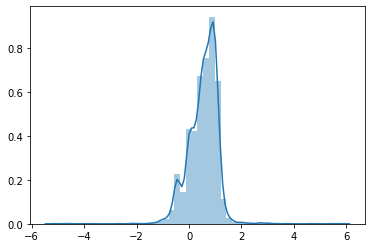

In [254]:
ols_results = []
for i in range(len(sample_seqs)):
    x = adjusted_diffs[i, :, exposure_col + 2].flatten()
    y = adjusted_diffs[i, :, outcome_col + 2].flatten()
    ols_res = sm.OLS(y, x).fit()
    ols_results.append(ols_res)
sns.distplot([ols_res.params[0] for ols_res in ols_results])

In [ ]:
ols_results = []
for i in range(len(sample_seqs)):
    x = adjusted_diffs[i, :, exposure_col + 2].flatten()
    y = adjusted_diffs[i, :, outcome_col + 2].flatten()
    ols_res = sm.OLS(y, x).fit()
    ols_results.append(ols_res)
sns.distplot([ols_res.params[0] for ols_res in ols_results])

In [255]:
ism_cis = [ols_res.params[0] for ols_res in ols_results]

In [262]:
wald_results = []
for i in range(len(sample_seqs)):
    wald_results.append(
        np.mean(adjusted_diffs[i, :, outcome_col + 2].flatten()) / np.mean(adjusted_diffs[i, :, exposure_col + 2].flatten())
    )

In [257]:
len(sample_seqs)

5013

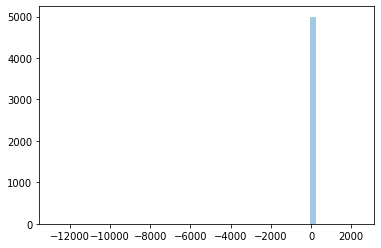

In [263]:
sns.distplot(wald_results, kde=False)

In [260]:
np.mean(ism_cis)

0.5365092619055613

In [259]:
output_dir = "../dat/sim_e2e_exp/res/2020-12-29-16-07-32/"
print(output_dir)
os.makedirs(output_dir, exist_ok=True)
with open(os.path.join(output_dir, f'{exposure_name}_{outcome_name}_true_ces.csv'), 'w') as f:
    f.write('seq, CI\n')
    for i, ci in enumerate(ism_cis):
        f.write(f'{i}, {ci}\n')

../dat/sim_e2e_exp/res/2020-12-29-16-07-32/


In [ ]:
output_dir = os.path.join(data_dir, 'res')
print(output_dir)
os.makedirs(output_dir, exist_ok=True)
with open(os.path.join(output_dir, 'GATA_TAL1_true_ces_no_conf.csv'), 'w') as f:
    f.write('seq, CI\n')
    for i, ci in enumerate(ism_cis_no_conf):
        f.write(f'{i}, {ci}\n')

In [ ]:
output_dir = os.path.join(data_dir, 'res')
print(output_dir)
os.makedirs(output_dir, exist_ok=True)
with open(os.path.join(output_dir, 'GATA_TAL1_true_ces_wald.csv'), 'w') as f:
    f.write('seq, CI\n')
    for i, ci in enumerate(wald_results):
        f.write(f'{i}, {ci}\n')